In [2]:
import os
import multiprocessing

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)
os.environ["JAX_PLATFORMS"] = "cpu"

from pymc_models import run_mcmc, run_mcmc_robust, rdm_model_simple
from simulation import rdm_experiment_simple
from priors import rdm_prior_simple
from data import load_hdf5
import blackjax
import jax
import jax.numpy as jnp

import numpy as np

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [81]:
data = load_hdf5("outputs/experiment_1/+default=true/test_data/test_data_sample_size_1000.hdf5")
observed = data["sim_data"][7,:,:]

In [104]:
data["prior_draws"][7,:]

array([3.02373582, 2.12469039, 0.23931306, 2.53893323, 0.01070426])

In [82]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, infos

In [83]:
logdensity_fun = rdm_model_simple(observed)

In [84]:
sampler_fun = blackjax.nuts

In [85]:
rng_key = jax.random.key(2025)
rng_key, warmup_key = jax.random.split(rng_key)

In [86]:
init_position = np.log(np.array([2.0, 2, 1.0, 2.0, 0.5*observed[:,0].min()]))

In [87]:
num_chains = 4

In [88]:
# warmup_key = jax.random.split(rng_key, num_chains)
# adapt = blackjax.meads_adaptation(logdensity_fun, num_chains=num_chains)
# (last_state, parameters), _ = adapt.run(rng_key, jax.vmap(lambda x: init_position)(np.arange(num_chains)), num_steps=2000)
# kernel = sampler_fun(logdensity_fun, **parameters).step

In [97]:
adapt = blackjax.window_adaptation(sampler_fun, logdensity_fun)
(last_state, parameters), _ = adapt.run(rng_key, init_position, num_steps=6000)
kernel = jax.jit(sampler_fun(logdensity_fun, **parameters).step)
parameters

{'step_size': Array(0.00648162, dtype=float64, weak_type=True),
 'inverse_mass_matrix': Array([1.05315472e-05, 1.32989222e-05, 5.15845146e-06, 3.92180992e-04,
        6.14844582e-04], dtype=float64)}

In [100]:
last_states = jax.vmap(lambda x: last_state)(np.arange(num_chains))

sample_keys = jax.random.split(rng_key, num_chains)

inference_loop_multiple_chains = jax.pmap(inference_loop, in_axes=(0, None, 0, None), static_broadcasted_argnums=(1, 3))

trace = inference_loop_multiple_chains(
    sample_keys, kernel, last_states, 6000
)


In [101]:
blackjax.diagnostics.potential_scale_reduction(trace[0].position)

Array([1.31635297, 1.99289504, 1.34095037, 1.29900605, 1.33500507],      dtype=float64)

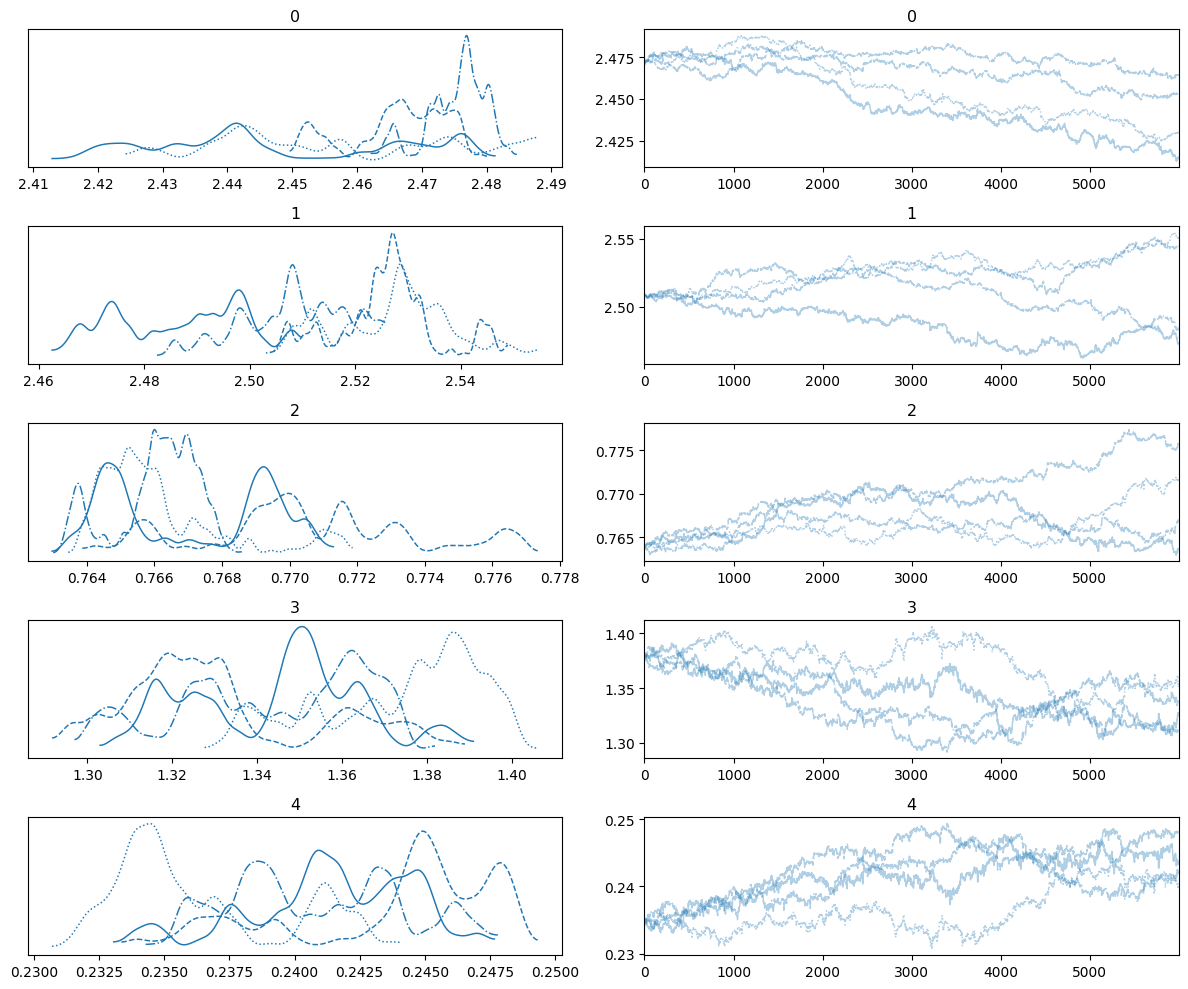

In [102]:
import matplotlib.pyplot as plt
import arviz as az

idata = az.from_dict(
    posterior={k: np.exp(trace[0].position[:,:,k])
               for k in range(5)})
az.plot_trace(idata)
plt.tight_layout()

In [243]:
finetune_key = jax.random.split(rng_key, num_chains)

def run_warmup(key, position, num_steps=2000):
    return adapt.run(key, position, num_steps=num_steps)

warmup_multiple_chains = jax.pmap(run_warmup, in_axes=(0, 0))

(finetune_state, parameters), finetune_obj = warmup_multiple_chains(finetune_key, trace_finetune[0].position[:,-1,:])
# kernel = jax.jit(sampler_fun(logdensity_fun, **parameters).step)

In [248]:
finetune_state

HMCState(position=Array([[ 1.06785938,  0.77859645, -0.1058622 ,  0.85350436, -1.01941786],
       [ 1.04444396,  0.69187385, -0.14452961,  0.82704959, -1.03332939],
       [ 1.0696268 ,  0.79051738, -0.06762405,  0.84005865, -0.97853537],
       [ 1.04740945,  0.7570056 , -0.13200499,  0.81919249, -1.00465772]],      dtype=float64), logdensity=Array([418.81210838, 420.21391597, 416.46625564, 418.84617415], dtype=float64), logdensity_grad=Array([[ -53.98836649,  -64.71140341,  -45.49303875,  129.18847759,
          91.56855028],
       [  -2.65249877,   11.49362934,  -50.44299985,   60.55452332,
          32.39558111],
       [  70.0926761 ,   10.29724723,  -36.4344396 , -111.99778779,
        -114.50928763],
       [ -97.72459045,  -73.0835698 ,  -26.8567883 ,  193.8124899 ,
         124.75501354]], dtype=float64))

In [244]:
blackjax.diagnostics.potential_scale_reduction(finetune_obj.state.position)

Array([1.01944868, 1.00562064, 1.01829858, 1.04531321, 1.05043415],      dtype=float64)

In [234]:
sample_keys = jax.random.split(rng_key, num_chains)

def kernel_inference_loop(key, parameters, position, num_steps):
    kernel = sampler_fun(logdensity_fun, **parameters).step
    return inference_loop(key, kernel, position, num_steps)

inference_loop_multiple_chains = jax.pmap(kernel_inference_loop, in_axes=(0, 0, 0, None), static_broadcasted_argnums=(3))

trace_finetune = inference_loop_multiple_chains(
    sample_keys, parameters, finetune_state, 2000
)

In [256]:
(last_state, _), _ = warmup_multiple_chains(finetune_key, trace[0].position[:,-1,:])

In [273]:
def run_warmup(key, position, num_steps=200):
    return adapt.run(key, position, num_steps=num_steps)

def kernel_inference_loop(key, parameters, position, num_steps):
    kernel = sampler_fun(logdensity_fun, **parameters).step
    return inference_loop(key, kernel, position, num_steps)

warmup_multiple_chains = jax.pmap(run_warmup, in_axes=(0, 0))
inference_loop_multiple_chains = jax.pmap(kernel_inference_loop, in_axes=(0, 0, 0, None), static_broadcasted_argnums=(3))

def finetune_mcmc(init_position):
    sample_keys = jax.random.split(rng_key, num_chains)
    finetune_keys = jax.random.split(rng_key, num_chains)

    is_converged = False

    max_iter = 30
    iter = 0

    init_state = jax.vmap(lambda x: init_position)(np.arange(num_chains))

    while not is_converged and iter < max_iter:
        (last_state, parameters), _ = warmup_multiple_chains(finetune_keys, init_state)
        trace = inference_loop_multiple_chains(
            sample_keys, parameters, last_state, 600
        )
        psrf = blackjax.diagnostics.potential_scale_reduction(trace[0].position)
        is_converged = np.all(psrf < 1.01)
        iter += 1
        init_state = trace[0].position[:,-1,:]
        print(iter, psrf)

    if is_converged:
        return trace
    
    print("not converged...")
    

In [274]:
finetune_mcmc(init_position)

1 [1.12397968 1.0166616  1.09691207 1.05946502 1.04841984]
2 [1.19012484 1.08697755 1.26646656 1.10207597 1.10973437]


KeyboardInterrupt: 

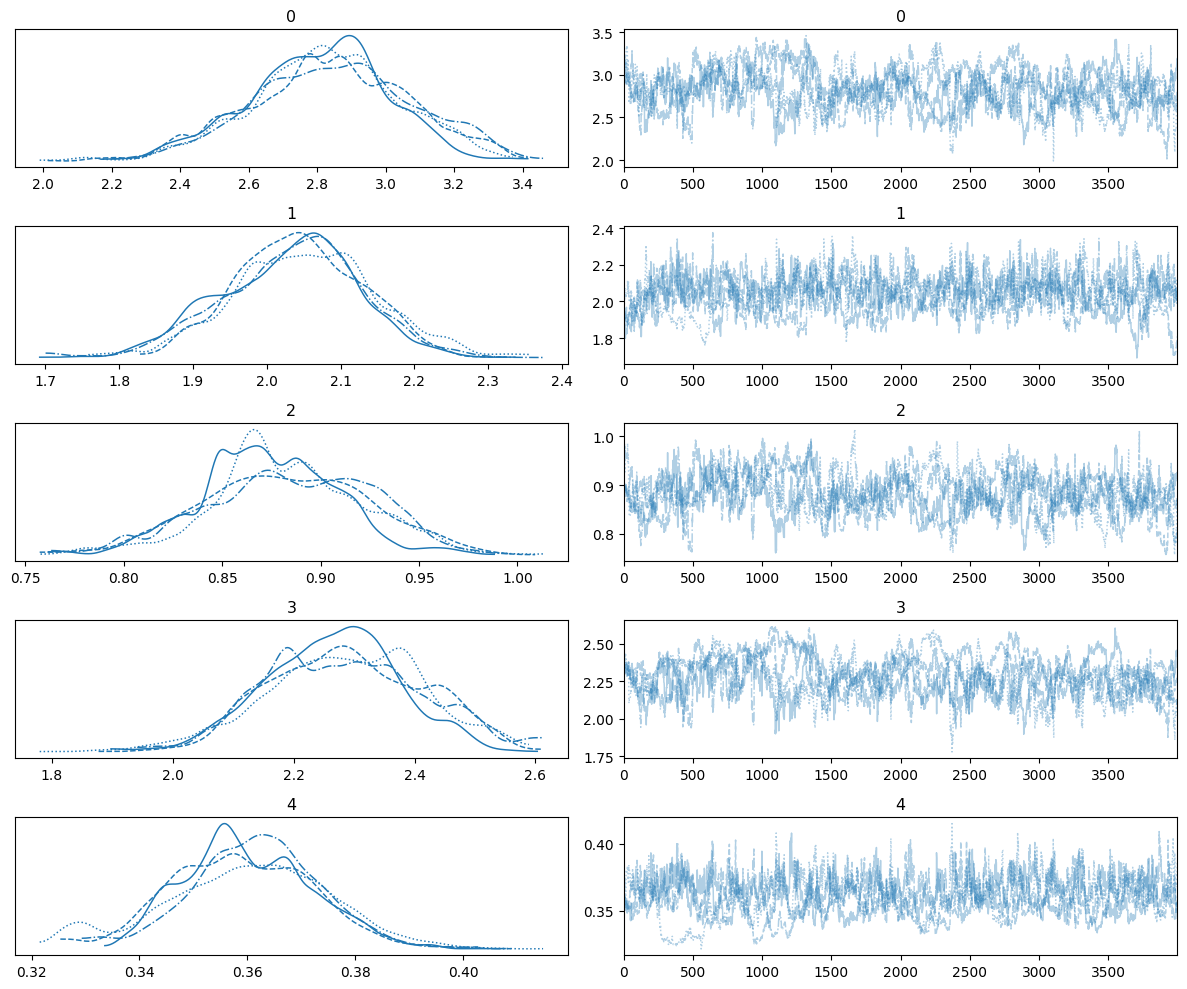

In [279]:
import matplotlib.pyplot as plt
import arviz as az

idata = az.from_dict(
    posterior={k: np.exp(trace[0].position[:,:,k])
               for k in range(5)})
az.plot_trace(idata)
plt.tight_layout()